# Generating panels for Figure 5

In [1]:
from Bio import SeqIO
from Bio import AlignIO
from difflib import SequenceMatcher
from Bio.Seq import Seq, MutableSeq

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os, progressbar, time
import matplotlib.pyplot as plt

In [2]:
HG_cds_fasta = '../../data/ortholog_dataset/uni_HG_cds_orthologs.faa'
MM_cds_fasta = '../../data/ortholog_dataset/uni_MM_cds_orthologs.faa'

In [3]:
MM_ATX = ['P28658', 'Q9CVD2']
HG_ATX = ['G5BVC0', 'G5AZL7']

## Profile of Mutational aggregation propensity (non-aligned)

In [4]:
MUT_RES_ATX = '/media/savvy/DATA3/savvy/project_2018/computational_mutagenesis/ATX/ATX_RESULTS'

In [7]:
def get_Seq(seqID, org):
    if 'MM' in org :
        for seqRecord in SeqIO.parse(MM_cds_fasta, format='fasta'):
            if seqRecord.id == seqID :
                return seqRecord
    elif 'HG' in org : 
        for seqRecord in SeqIO.parse(HG_cds_fasta, format='fasta'):
            if seqRecord.id == seqID :
                return seqRecord

def calculate_mutation_metrics_v2(agg_table, seqRecord, threshold):
    ### Normalized delta Mutational Aggregation Propensity
    seq_length = len(seqRecord.seq.translate(to_stop=True))
    print(seqRecord.seq.translate(to_stop=True))
    print('Protein length:', seq_length)
    agg_table['deltaAgg'] = (agg_table['Aggregation'] / seq_length) - (agg_table['Aggregation'][0] / seq_length)
    
    agg_table = agg_table[1:].reset_index(drop=True)

    ### No need on new run - non valid mutants already removed
    # agg_table['valid_mutant'] = agg_table['Sequence'].apply(isValid, args=(seqRecord,)) 
    # valid_mutants = agg_table[agg_table['valid_mutant'] == True]
    valid_mutants = agg_table
    print('Number of non redundant mutations:', len(valid_mutants))
    # print(len(valid_mutants[valid_mutants['deltaAgg'] == 0 ]))
    mutTol_v1 = len(valid_mutants[valid_mutants['deltaAgg'] == 0 ]) / len(valid_mutants)
    mutTol_v2 = len(valid_mutants[valid_mutants['deltaAgg'] <= 0 ]) / len(valid_mutants)
    mutTol_v3 = len(valid_mutants[valid_mutants['deltaAgg'] >= 0 ]) / len(valid_mutants)
    mutTol_v4 = len(valid_mutants[valid_mutants['deltaAgg'] < - threshold ]) / len(valid_mutants)
    return mutTol_v1, mutTol_v2, mutTol_v3, mutTol_v4

def get_aa_changes(seq_id, seqRecord, output_type):
    i = int(seq_id.split('_')[1])
    REF = seq_id.split('_')[2][0]
    ALT = seq_id.split('_')[2][1]
    REF_SEQ = str(seqRecord.seq.translate(to_stop=True))
    mutant = MutableSeq(str(seqRecord.seq))
    mutant[i] = ALT
    ALT_SEQ = str(Seq(str(mutant)).translate(to_stop=True))
    for j in range(len(REF_SEQ)) :
        if REF_SEQ[j] != ALT_SEQ[j]:
            if 'aa' in output_type:
                return f'{j+1}{REF_SEQ[j]}{ALT_SEQ[j]}'
            if 'idx' in output_type:
                return j+1          


def studycase_plot(agg_table, seqRecord, title):
    seq_length = len(seqRecord.seq.translate(to_stop=True))
    agg_table['deltaAgg'] = (agg_table['Aggregation'] / seq_length) - (agg_table['Aggregation'][0] / seq_length)

    agg_table = agg_table[1:].reset_index(drop=True)
    agg_table['aa_changes'] = agg_table['Sequence'].apply(get_aa_changes, args=(seqRecord,'aa')) 
    agg_table['res_idx'] = agg_table['Sequence'].apply(get_aa_changes, args=(seqRecord,'idx')) 
    # print(agg_table)

    #### Distribution of mutational Agg scores
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=False)

    sns.kdeplot(data=agg_table, x='deltaAgg', ax=axes[0])
    axes[0].set_xlabel('Mutational aggregation propensity score')

    #### Mutational aggregation propensity along the amino acid sequence
    sns.scatterplot(data=agg_table, y='deltaAgg', x='res_idx')
    axes[1].set_ylabel('Mutational aggregation propensity score')
    axes[1].set_xlabel('Residue position\n')
    f.suptitle(title)
    plt.show()

    f.savefig(f'../../figures/revisions/atx_proteins/{title}.png', dpi=250)
    return agg_table


def get_mutTol_scores_v2(proteinID, org, threshold, title):
     tmp = pd.read_csv(os.path.join(MUT_RES_ATX,f'{proteinID}_aggregation.txt'), sep='\t')
     seqRecord = get_Seq(proteinID, org)
     mutTol_v1, mutTol_v2, mutTol_v3, mutTol_v4 = calculate_mutation_metrics_v2(tmp, seqRecord,  threshold)
     agg_table = studycase_plot(tmp, seqRecord, title)
     return agg_table, mutTol_v1, mutTol_v2, mutTol_v3, mutTol_v4



P28658
MAAPRMPPSRLSGIMVPAPIQDLEALRALTALFKEQRNRETAPRTIFQRVLDILKKSTHAVELACRDPSQVEHLASSLQLITECFRCLRNACIECSVNQNSIRNLDTIGVAVDLVLLFRELRVEQDSLLTAFRCGLQFLGNVASRNEESQSIVWVHAFPELFMSCLNHPDKKIVAYCSMILFTSLNAERMKDLEENLNIAINVIEAHQKHPASEWPFLIISDHFLKSPELVEAMYGKLSNQERITLLDIVIAKLVGEEQLTKDDISIFVRHAELIANSFMDQCRNVLKLTSEPHTEDKEALVTIRLLDVLCEMTSNTELLGYLQVFPGLMERVIDVLRVIHEVGKESTNIFSPSDSLKAEGDIEHMTEGFKSHLIRLIGNLCYKNKENQDKVNELDGIPLILDSSNIDDNNPFMMQWVVYAVRNLTEDNSQNQDVIAKMEEQGLADASLLKKMGFEIEKSGDKLILKSNNDIPPP
Protein length: 475
Number of non redundant mutations: 2835


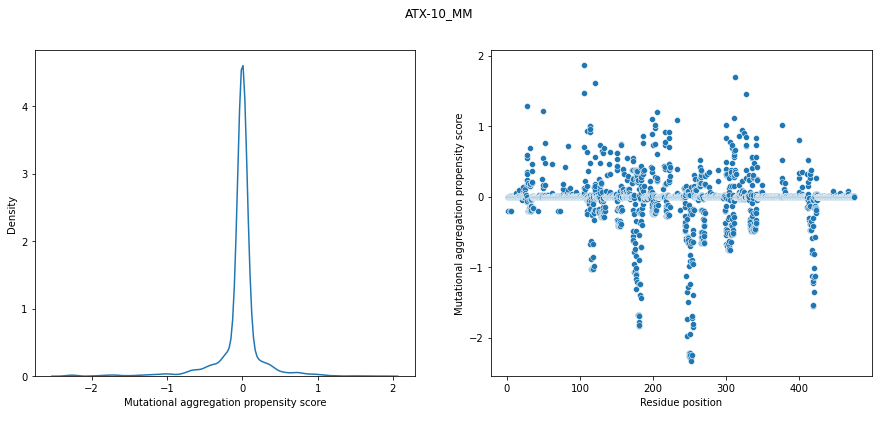

0.2800705467372134 0.6105820105820106 0.6694885361552029 0.0028218694885361554
Q9CVD2
MESIFHEKQEGSLCAQHCLNNLLQGEYFSPVELSSIAHQLDEEERLRMAEGGVTSEDYRTFLQQPSGNMDDSGFFSIQVISNALKVWGLELILFNSPEYQRLRIDPINERSFICNYKEHWFTVRKLGKQWFNLNSLLTGPELISDTYLALFLAQLQQEGYSIFVVKGDLPDCEADQLLQMIKVQQMHRPKLIGEELAHLKEQSALKADLERVLEAADGSGIFDEDEDDLQRALAISRQEIDMEDEEADLRRAIQLSMQGSSRSMCENSPQTSSPDLSSEELRRRREAYFEKQQQQQQEVDRPGPLSYPRERPTTSSGGRRSDQGGDAVSEEDMLRAAVTMSLETAKDNLKAERKK
Protein length: 355
Number of non redundant mutations: 2077


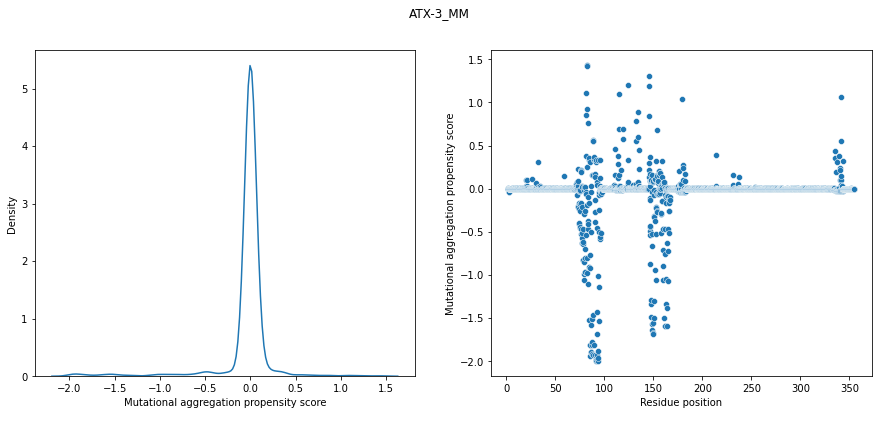

0.4207992296581608 0.6803081367356765 0.7404910929224844 0.00048146364949446316


In [8]:
print(MM_ATX[0])
MM_ATX10_deltaAgg_table, mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x = get_mutTol_scores_v2(MM_ATX[0], 'MM', 2, 'ATX-10_MM')
print(mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x)

print(MM_ATX[1])
MM_ATX3_deltaAgg_table, mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x = get_mutTol_scores_v2(MM_ATX[1], 'MM', 2, 'ATX-3_MM')
print(mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x)

G5BVC0
MAAPRPQPARLSGILIPAPIQDLEALRALTALFKEQRNRETAPRTIFQRVLDILKRSSHAVELACRDPTQVEHLASSLQLITECFRCLRNACIECSVNQNSIRNLDTIGVAVDLILLFRELRVEQDALLTAFRCGLQFLGNIASRNEDSQSIVWVHAFPELFMSCLNHPDKKIVAYCSMILFTSLNSERMKELEENLNIAINVIEAHQKQPESEWPFLIITDHFLKNPELVQAMYAKLSHQERVTLLDLMIAKLVNDEQLTKDEISVFLHHAELIASSFVDQCRTVLKLTSEPHAEDEEVLATIRLLDVLCEMTANTELLGYLQVFPGLLEGVIDLLQMIHVTGKDTTNIFSTSGCVRAEGDVSNMAEGFKSHLIRLIGNLCYKNKDNQDKVNELDGIPLILDSCSIDDSNPWLCPQPSAEEAESLALALPQLAASPEGLLQNLAYSPHFTSELYVRNWPSGVDSAQGTAPVLTQWVVYAIRNLTEDNSQNQDLIAKLEDQGLADASLLKKMGFEVEKRGEKLILKSTRDPPLRIVGCGRTCSFCSRARVQVEKGKEQNEEVLAATSLPEKGTFDWAGSLGRVETDF
Protein length: 587
Number of non redundant mutations: 3460


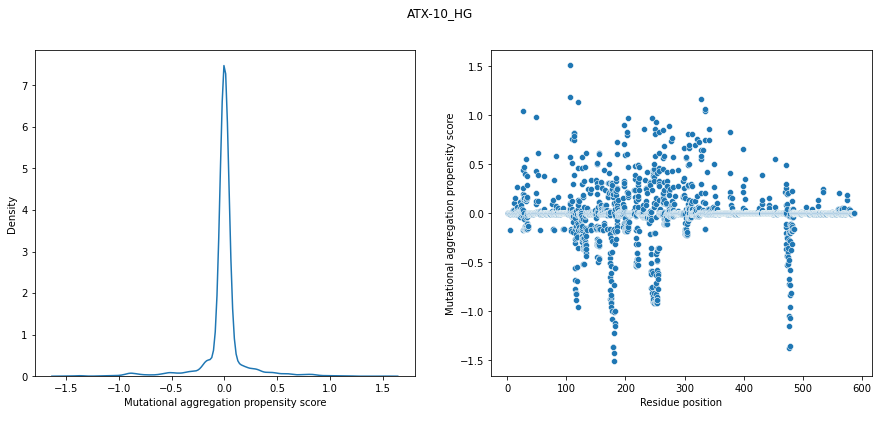

0.18497109826589594 0.5043352601156069 0.680635838150289 0.0
G5AZL7
MFPPPRLPLCGLRIWQIPRSRFRQWGWLRSKLPLVVGSLLAPSLKVGQGSLAGLGGSDCGRAGGKSSGKAFGSDVRVWCGGLGLPREGEGKRNTFVLEWTAELRFLSGGFWEGYFEAIIIGKRFYRNEKSFICNYKEHWFTVRKLGKQWFNLNSLLTGPELISDTYLALFLAQLQQEGYSIFVVKGDLPDCEADQLLQMIRVQQMHRPKLLGEELAQLKEQRVLKTDLEQVLEGNDGSGMLDEDEEDLQRALALSRQEIDMEDEEADLRRAIQLSMQGSSSISQDVPQTSGTNLTFEELRKRREAYFEKQQQQQQQQTDPPGQASQPCERPTTSSGGLGSDLGDSMSEEDMLQAAVTMSLETVTNNLKTEGKK
Protein length: 373
Number of non redundant mutations: 2155


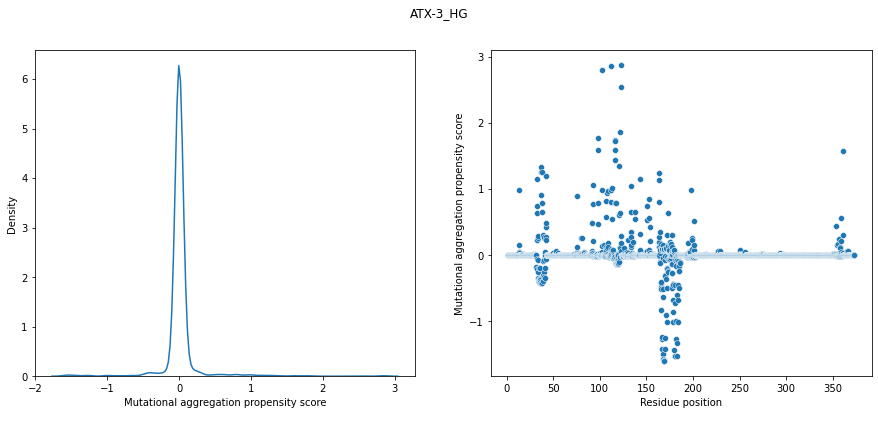

0.40278422273781905 0.6464037122969838 0.7563805104408353 0.0


In [9]:
print(HG_ATX[0])
HG_ATX10_deltaAgg_table, mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x = get_mutTol_scores_v2(HG_ATX[0], 'HG', 2, 'ATX-10_HG')
print(mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x)

print(HG_ATX[1])
HG_ATX3_deltaAgg_table, mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x = get_mutTol_scores_v2(HG_ATX[1], 'HG', 2, 'ATX-3_HG')
print(mutTol_v1_x, mutTol_v2_x, mutTol_v3_x, mutTol_v4_x)

________

In [10]:
def get_msa_mapping(alignment, i):
    wt_seq = alignment[i].seq.replace('-', '')
    msa_seq = alignment[i].seq

    seq_index = []
    for j in range(len(wt_seq)):
        seq_index.append([j+1, wt_seq[j]])

    msa_index = [] 

    for k in range(len(msa_seq)):
        msa_index.append([k+1, msa_seq[k]])

    seq = pd.DataFrame(seq_index, columns=['seq_idx', 'seq_AA'])
    msa = pd.DataFrame(msa_index, columns=['msa_idx', 'msa_AA'])

    msa = msa[msa['msa_AA'] != '-'].reset_index(drop=True)
    msa_mapping = seq.join(msa)
    return msa_mapping

In [11]:
def get_msa_pos(x, msa_mapping):
    return msa_mapping[msa_mapping['seq_idx'] == x]['msa_idx'].values[0]

def getAgg(x, table):
    try:
        return table[table['seq_idx'] == x]['Aggregation'].values[0]
    except:
        return np.nan

## ATX-10

In [12]:
ATX10_alignment = AlignIO.read(open("../../data/atx_proteins/alignment/outputs/rod_ATX-10.msa"), "fasta")
ATX10_MM_msa_mapping = get_msa_mapping(ATX10_alignment, 0)
ATX10_HG_msa_mapping = get_msa_mapping(ATX10_alignment, 1)

MM_ATX10_deltaAgg_table['msa_idx'] = MM_ATX10_deltaAgg_table['res_idx'].apply(get_msa_pos, args=(ATX10_MM_msa_mapping,))
HG_ATX10_deltaAgg_table['msa_idx'] = HG_ATX10_deltaAgg_table['res_idx'].apply(get_msa_pos, args=(ATX10_HG_msa_mapping,))

In [13]:
i = 0
HG_aggTable = f'{HG_ATX[i]}.txt'
tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/HG/'
HG_ATX10_agg = pd.read_csv(os.path.join(tango_output, HG_aggTable), sep='\t')[['res', 'Aggregation']].rename(columns={'res':'seq_idx'})

tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/MM/'
MM_aggTable = f'{MM_ATX[i]}.txt'
MM_ATX10_agg = pd.read_csv(os.path.join(tango_output, MM_aggTable), sep='\t')[['res', 'aa', 'Aggregation']].rename(columns={'res':'seq_idx'})

ATX10_HG_msa_mapping['HG_Aggregation'] = ATX10_HG_msa_mapping['seq_idx'].apply(getAgg, args=(HG_ATX10_agg,))
ATX10_MM_msa_mapping['MM_Aggregation'] = ATX10_MM_msa_mapping['seq_idx'].apply(getAgg, args=(MM_ATX10_agg,))

ATX10_AGG = ATX10_HG_msa_mapping.merge(ATX10_MM_msa_mapping, on=['msa_idx'], how='left', suffixes=['_HG', '_MM'])

In [14]:
ATX10_AGG[414:475]

,seq_idx_HG,seq_AA_HG,msa_idx,msa_AA_HG,HG_Aggregation,seq_idx_MM,seq_AA_MM,msa_AA_MM,MM_Aggregation
414,415,C,415,C,0.000,415.0,M,M,48.832
415,416,P,416,P,0.000,NaN,NaN,NaN,NaN
416,417,Q,417,Q,0.000,NaN,NaN,NaN,NaN
417,418,P,418,P,0.000,NaN,NaN,NaN,NaN
418,419,S,419,S,0.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
470,471,P,471,P,0.747,NaN,NaN,NaN,NaN
471,472,V,472,V,60.789,NaN,NaN,NaN,NaN
472,473,L,473,L,65.745,NaN,NaN,NaN,NaN
473,474,T,474,T,66.604,NaN,NaN,NaN,NaN


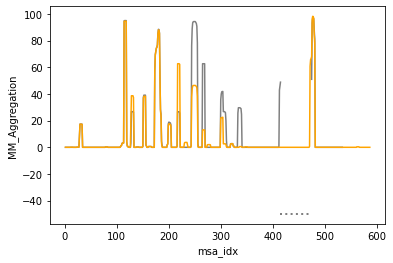

In [17]:
sns.lineplot(y=ATX10_AGG['MM_Aggregation'][:415], x=ATX10_AGG['msa_idx'][:415], color='grey')
sns.lineplot(y=ATX10_AGG['MM_Aggregation'][474:] , x=ATX10_AGG['msa_idx'][474:], color='grey')
sns.lineplot(data=ATX10_AGG, x='msa_idx', y='HG_Aggregation', color='orange')
plt.hlines(y=-50, xmin=414, xmax=474, linewidth=2, linestyles='dotted', color='grey')

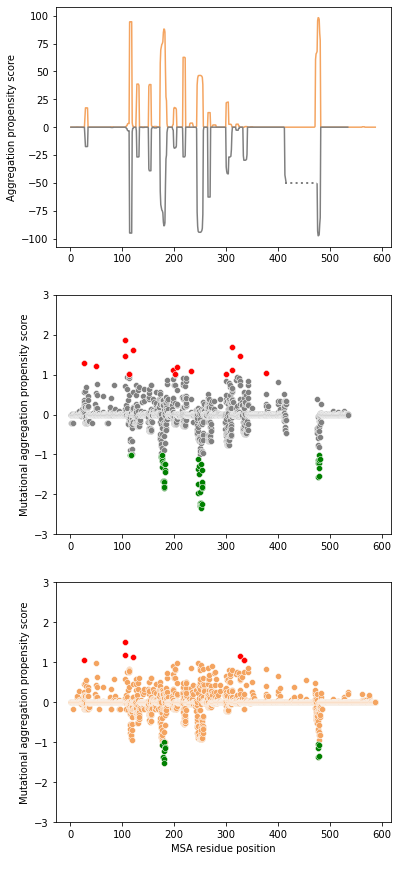

In [20]:
title= 'ATX-10_deltaAgg_distribution'
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,15), sharex=True)

ATX10_AGG['MM_Aggregation'] = - ATX10_AGG['MM_Aggregation']

sns.lineplot(data=ATX10_AGG, x='msa_idx', y='HG_Aggregation', color='sandybrown', ax=axes[0])
sns.lineplot(y=ATX10_AGG['MM_Aggregation'][:415], x=ATX10_AGG['msa_idx'][:415], color='grey', ax=axes[0])
sns.lineplot(y=ATX10_AGG['MM_Aggregation'][474:] , x=ATX10_AGG['msa_idx'][474:], color='grey', ax=axes[0])
axes[0].hlines(y=-50, xmin=414, xmax=474, linewidth=2, linestyles='dotted', color='grey')
axes[0].set_ylabel('Aggregation propensity score')
axes[0].set_xlabel('MSA residue position\n')
axes[0].tick_params(labelbottom=True)

#### Mutational aggregation propensity along the amino acid sequence
sns.scatterplot(data=MM_ATX10_deltaAgg_table, y='deltaAgg', x='msa_idx', color='grey', ax=axes[1])
sns.scatterplot(data=MM_ATX10_deltaAgg_table[MM_ATX10_deltaAgg_table['deltaAgg'] >= 1 ], y='deltaAgg', x='msa_idx', color='red', ax=axes[1])
sns.scatterplot(data=MM_ATX10_deltaAgg_table[MM_ATX10_deltaAgg_table['deltaAgg'] <= -1 ], y='deltaAgg', x='msa_idx', color='green', ax=axes[1])
axes[1].set_ylabel('Mutational aggregation propensity score')
axes[1].set_xlabel('MSA residue position\n')
axes[1].set_ylim([-3,3])
axes[1].tick_params(labelbottom=True)
# axes[2].set_title('ATX-10 (Mus musculus)\n')

sns.scatterplot(data=HG_ATX10_deltaAgg_table, y='deltaAgg', x='msa_idx', color='sandybrown', ax=axes[2])
sns.scatterplot(data=HG_ATX10_deltaAgg_table[HG_ATX10_deltaAgg_table['deltaAgg'] >= 1 ], y='deltaAgg', x='msa_idx', color='red', ax=axes[2])
sns.scatterplot(data=HG_ATX10_deltaAgg_table[HG_ATX10_deltaAgg_table['deltaAgg'] <= -1 ], y='deltaAgg', x='msa_idx', color='green', ax=axes[2])
axes[2].set_ylabel('Mutational aggregation propensity score')
axes[2].set_xlabel('MSA residue position\n')
axes[2].set_ylim([-3,3])
# axes[2].set_title('ATX-10 (Heterocephalus glaber)\n')

f.savefig(f'../../figures/revisions/atx_proteins/{title}.png', dpi=250)
plt.show()

In [36]:
sum(ATX10_AGG['HG_Aggregation']) / len(ATX10_AGG)

6.63171720613288

In [42]:
sum(ATX10_AGG['MM_Aggregation'].dropna()) / len(ATX10_AGG)

8.193466780238502

In [55]:
len('FKSHLIRLIGNLCYKNKDNQDKVNELDGIPLILDSCSIDDSNPWL')

45

In [16]:
ATX10_alignment[0].seq[416:474]

Seq('----------------------------------------------------------')

In [62]:
ATX10_alignment[1].seq[413-43-1:413]

Seq('FKSHLIRLIGNLCYKNKDNQDKVNELDGIPLILDSCSIDDSNPW')

In [17]:
ATX10_alignment[1].seq[416:474]

Seq('QPSAEEAESLALALPQLAASPEGLLQNLAYSPHFTSELYVRNWPSGVDSAQGTAPVLT')

_________

## ATX-3

In [21]:
ATX3_alignment = AlignIO.read(open("../../data/atx_proteins/alignment/outputs/rod_ATX-3.msa"), "fasta")
ATX3_MM_msa_mapping = get_msa_mapping(ATX3_alignment, 0)
ATX3_HG_msa_mapping = get_msa_mapping(ATX3_alignment, 1)

MM_ATX3_deltaAgg_table['msa_idx'] = MM_ATX3_deltaAgg_table['res_idx'].apply(get_msa_pos, args=(ATX3_MM_msa_mapping,))
HG_ATX3_deltaAgg_table['msa_idx'] = HG_ATX3_deltaAgg_table['res_idx'].apply(get_msa_pos, args=(ATX3_HG_msa_mapping,))

In [22]:
i = 1
HG_aggTable = f'{HG_ATX[i]}.txt'
tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/HG/'
HG_ATX3_agg = pd.read_csv(os.path.join(tango_output, HG_aggTable), sep='\t')[['res', 'Aggregation']].rename(columns={'res':'seq_idx'})

tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/MM/'
MM_aggTable = f'{MM_ATX[i]}.txt'
MM_ATX3_agg = pd.read_csv(os.path.join(tango_output, MM_aggTable), sep='\t')[['res', 'aa', 'Aggregation']].rename(columns={'res':'seq_idx'})

ATX3_HG_msa_mapping['HG_Aggregation'] = ATX3_HG_msa_mapping['seq_idx'].apply(getAgg, args=(HG_ATX3_agg,))
ATX3_MM_msa_mapping['MM_Aggregation'] = ATX3_MM_msa_mapping['seq_idx'].apply(getAgg, args=(MM_ATX3_agg,))

ATX3_AGG = ATX3_HG_msa_mapping.merge(ATX3_MM_msa_mapping, on=['msa_idx'], how='left', suffixes=['_HG', '_MM'])

In [23]:
ATX3_AGG[60:80] 

,seq_idx_HG,seq_AA_HG,msa_idx,msa_AA_HG,HG_Aggregation,seq_idx_MM,seq_AA_MM,msa_AA_MM,MM_Aggregation
60,61,R,87,R,0.0,NaN,NaN,NaN,NaN
61,62,A,88,A,0.0,NaN,NaN,NaN,NaN
62,63,G,89,G,0.0,72.0,S,S,0.057
63,64,G,90,G,0.0,73.0,G,G,1.620
64,65,K,91,K,0.0,74.0,F,F,36.059
65,66,S,92,S,0.0,75.0,F,F,38.769
66,67,S,93,S,0.0,76.0,S,S,38.985
67,68,G,94,G,0.0,77.0,I,I,44.035
68,69,K,95,K,0.0,78.0,Q,Q,44.266
69,70,A,96,A,0.0,79.0,V,V,54.720


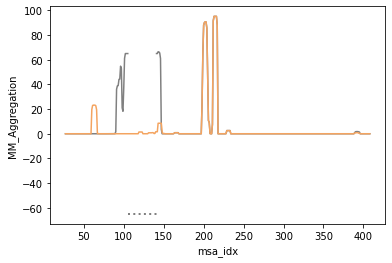

In [24]:
sns.lineplot(y=ATX3_AGG['MM_Aggregation'][:79], x=ATX3_AGG['msa_idx'][:79], color='grey')
sns.lineplot(y=ATX3_AGG['MM_Aggregation'][114:] , x=ATX3_AGG['msa_idx'][114:], color='grey')
sns.lineplot(data=ATX3_AGG, x='msa_idx', y='HG_Aggregation', color='sandybrown')
plt.hlines(y=-65, xmin=105, xmax=141, linewidth=2, linestyles='dotted', color='grey')

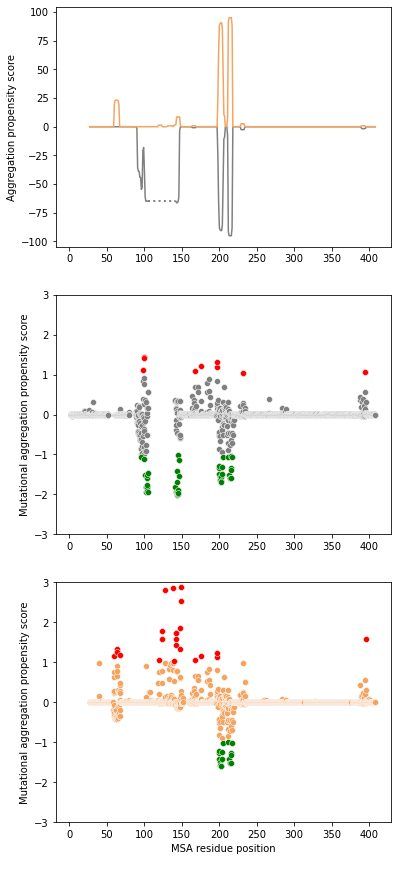

In [28]:
title= 'ATX-3_deltaAgg_distribution'

ATX3_AGG['MM_Aggregation'] = - ATX3_AGG['MM_Aggregation']

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,15), sharex=True)

sns.lineplot(y=ATX3_AGG['MM_Aggregation'][:79], x=ATX3_AGG['msa_idx'][:79], color='grey', ax=axes[0])
sns.lineplot(y=ATX3_AGG['MM_Aggregation'][114:] , x=ATX3_AGG['msa_idx'][114:], color='grey', ax=axes[0])
sns.lineplot(data=ATX3_AGG, x='msa_idx', y='HG_Aggregation', color='sandybrown', ax=axes[0])
axes[0].hlines(y=-65, xmin=105, xmax=141, linewidth=2, linestyles='dotted', color='grey')
axes[0].set_ylabel('Aggregation propensity score')
axes[0].set_xlabel('MSA residue position\n')
axes[0].tick_params(labelbottom=True)


#### Mutational aggregation propensity along aligned amino acid sequence

sns.scatterplot(data=MM_ATX3_deltaAgg_table, y='deltaAgg', x='msa_idx', color='grey', ax=axes[1])
sns.scatterplot(data=MM_ATX3_deltaAgg_table[MM_ATX3_deltaAgg_table['deltaAgg'] >= 1 ], y='deltaAgg', x='msa_idx', color='red', ax=axes[1])
sns.scatterplot(data=MM_ATX3_deltaAgg_table[MM_ATX3_deltaAgg_table['deltaAgg'] <= -1 ], y='deltaAgg', x='msa_idx', color='green', ax=axes[1])
axes[1].set_ylabel('Mutational aggregation propensity score')
axes[1].set_xlabel('MSA residue position\n')
axes[1].tick_params(labelbottom=True)
axes[1].set_ylim([-3,3])
# axes[1].set_title('ATX-3 (Mus musculus)\n')


sns.scatterplot(data=HG_ATX3_deltaAgg_table, y='deltaAgg', x='msa_idx', color='sandybrown', ax=axes[2])
sns.scatterplot(data=HG_ATX3_deltaAgg_table[HG_ATX3_deltaAgg_table['deltaAgg'] >= 1 ], y='deltaAgg', x='msa_idx', color='red', ax=axes[2])
sns.scatterplot(data=HG_ATX3_deltaAgg_table[HG_ATX3_deltaAgg_table['deltaAgg'] <= -1 ], y='deltaAgg', x='msa_idx', color='green', ax=axes[2])
axes[2].set_ylabel('Mutational aggregation propensity score')
axes[2].set_xlabel('MSA residue position\n')
axes[2].set_ylim([-3,3])
# axes[2].set_title('ATX-3 (Heterocephalus glaber)\n')

f.savefig(f'../../figures/revisions/atx_proteins/{title}.png', dpi=250)
plt.show()

In [27]:
sum(ATX3_AGG['HG_Aggregation']) / len(ATX10_AGG)

2.395272572402045

In [48]:
sum(ATX3_AGG['MM_Aggregation'].dropna()) / len(ATX3_AGG)

6.157163538873996

In [21]:
ATX3_alignment[0].seq[53:60]

Seq('-------')

In [22]:
ATX3_alignment[1].seq[53:60]

Seq('LRSKLPL')

In [364]:
ATX3_alignment[0].seq[80:88]

Seq('--------')

In [365]:
ATX3_alignment[1].seq[80:88]

Seq('GGSDCGRA')

In [366]:
ATX3_alignment[0].seq[106:140]

Seq('----------------------------------')

In [110]:
ATX3_alignment[1].seq[106:140]

Seq('GLGLPREGEGKRNTFVLEWTAELRFLSGGFWEGY')